# Language Modeling

In [683]:
import os
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import pandas as pd
import string
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import seaborn as sns
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score, precision_recall_fscore_support
import numpy as np
from sklearn.metrics import silhouette_samples
from sklearn.metrics import davies_bouldin_score, normalized_mutual_info_score
from scipy.spatial.distance import cdist
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [347]:
folder_path = "text"

if not os.path.exists(folder_path):
    print("התיקייה לא נמצאה. בדוק את הנתיב.")

In [349]:
# נתיב לתיקיית הקבצים
folder_path = "text"  # שנה את הנתיב אם צריך

# קריאת כל המסמכים
documents = []
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):  # בודקים שהקובץ הוא מסוג TXT
        file_path = os.path.join(folder_path, filename)
        try:
            # ניסיון לקרוא את הקובץ עם קידוד UTF-8, אם לא מצליחים, ננסה קידוד חלופי
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                documents.append(content)
                print(f"הקובץ {filename} נקרא בהצלחה.")
        except UnicodeDecodeError:  # אם קריאה ב-UTF-8 נכשלת, ננסה קידוד אחר
            try:
                with open(file_path, 'r', encoding='ISO-8859-1') as file:
                    content = file.read()
                    documents.append(content)
                    print(f"הקובץ {filename} נקרא בהצלחה")
            except Exception as e:
                print(f"שגיאה בקריאת הקובץ {filename} ")
        except Exception as e:
            print(f"שגיאה בקריאת הקובץ {filename}: {e}")

# בדיקת התוצאה
if documents:
    print(f"נמצאו {len(documents)} קבצים מסוג .txt בתיקייה {folder_path}.")
else:
    print(f"לא נמצאו קבצים מסוג .txt בתיקייה {folder_path}.")


הקובץ A Survey of Personalized News Recommendation.txt נקרא בהצלחה
הקובץ A Survey on Personalized News Recommendation Technology.txt נקרא בהצלחה.
הקובץ AContextual-BanditApproachto Personalized News Article Recommendation.txt נקרא בהצלחה.
הקובץ Adaptive News Access.txt נקרא בהצלחה.
הקובץ AI-News_Personalization_System_Combining_Complete_Content_Characterization_and_Full_Term_Interest_Portrayal_in_the_Big_Data_Era.txt נקרא בהצלחה.
הקובץ Algorithms and System Architecture for Immediate Personalized.txt נקרא בהצלחה.
הקובץ Anadaptive system for the personalized access to news.txt נקרא בהצלחה.
הקובץ Analyzing the News Coverage of Personalized Newspapers.txt נקרא בהצלחה.
הקובץ An_adaptive_personalized_news_disseminat.txt נקרא בהצלחה.
הקובץ DoNotReadtheSameNews!.txt נקרא בהצלחה.
הקובץ Emotion-Provoking Personalization of News Informing Citizens and Closing the Knowledge Gap.txt נקרא בהצלחה.
הקובץ Explanations of news personalisation across countries and.txt נקרא בהצלחה.
הקובץ Exploiting Searc

In [425]:
# הורדת משאבי NLTK הדרושים
nltk.download('punkt')

# ביצוע טוקניזציה לכל המסמכים והסרת סימני פיסוק ומספרים
try:
    tokenized_documents = [
        [word for word in word_tokenize(doc) if word.isalpha()] for doc in documents
    ]
    print("הטוקניזציה בוצעה בהצלחה, סימני הפיסוק והמספרים הוסרו.")
except Exception as e:
    print(f"שגיאה בביצוע הטוקניזציה: {e}")

# בדיקת התוצאה
if tokenized_documents:
    print(f"בוצעה טוקניזציה ל-{len(tokenized_documents)} מסמכים.")
    print(f"דוגמה מהטוקניזציה של המסמך הראשון: {tokenized_documents[0][:10]}")
else:
    print("רשימת המסמכים לטוקניזציה ריקה.")


הטוקניזציה בוצעה בהצלחה, סימני הפיסוק והמספרים הוסרו.
בוצעה טוקניזציה ל-50 מסמכים.
דוגמה מהטוקניזציה של המסמך הראשון: ['Data', 'Science', 'and', 'Engineering', 'https', 'PAPERS', 'A', 'Survey', 'of', 'Personalized']


In [353]:
# מודל שפה ראשוני (לפני עיבוד כלשהו)
original_language_model = Counter(word for doc in tokenized_documents for word in doc)

print("מודל השפה הראשוני נבנה.")
print(f"מספר המילים הייחודיות במודל השפה הראשוני: {len(original_language_model)}")
print(f"דוגמה למילים הנפוצות ביותר: {original_language_model.most_common(10)}")


מודל השפה הראשוני נבנה.
מספר המילים הייחודיות במודל השפה הראשוני: 22973
דוגמה למילים הנפוצות ביותר: [('the', 22693), ('of', 14344), ('and', 12630), ('to', 9814), ('news', 7469), ('in', 7165), ('a', 6979), ('is', 4914), ('on', 4293), ('for', 4136)]


In [357]:
# יצירת רשימת Stop Words באנגלית
stop_words = set(stopwords.words('english'))

# סינון מילים חסרות חשיבות תוך שמירה על המילים המקוריות
filtered_documents = [
    [word for word in doc if word.lower() not in stop_words] for doc in tokenized_documents
]

print("הסרת מילים חסרות חשיבות הושלמה.")

# בדיקת התוצאה
if filtered_documents:
    print(f"בוצע סינון ל-{len(filtered_documents)} מסמכים.")
    print(f"דוגמה לאחר הסרת Stop Words מהמסמך הראשון: {filtered_documents[0][:10]}")
else:
    print("רשימת המסמכים לסינון ריקה.")


הסרת מילים חסרות חשיבות הושלמה.
בוצע סינון ל-50 מסמכים.
דוגמה לאחר הסרת Stop Words מהמסמך הראשון: ['Data', 'Science', 'Engineering', 'https', 'PAPERS', 'Survey', 'Personalized', 'News', 'Recommendation', 'Xiangfu']


In [359]:
# מודל שפה לאחר הסרת Stop Words
filtered_language_model = Counter(word for doc in filtered_documents for word in doc)

print("מודל השפה לאחר הסרת Stop Words נבנה.")
print(f"מספר המילים הייחודיות: {len(filtered_language_model)}")
print(f"דוגמה למילים הנפוצות ביותר: {filtered_language_model.most_common(10)}")


מודל השפה לאחר הסרת Stop Words נבנה.
מספר המילים הייחודיות: 22688
דוגמה למילים הנפוצות ביותר: [('news', 7469), ('user', 3440), ('users', 2228), ('recommendation', 1479), ('information', 1400), ('personalization', 1326), ('News', 1249), ('content', 1079), ('personalized', 1054), ('articles', 1052)]


In [361]:
print(f"מספר המילים במודל הראשוני: {len(original_language_model)}")
print(f"מספר המילים לאחר הסרת Stop Words: {len(filtered_language_model)}")

# השוואת מילים נפוצות
print("מילים נפוצות במודל הראשוני:")
print(original_language_model.most_common(10))
print("מילים נפוצות במודל לאחר סינון:")
print(filtered_language_model.most_common(10))


מספר המילים במודל הראשוני: 22973
מספר המילים לאחר הסרת Stop Words: 22688
מילים נפוצות במודל הראשוני:
[('the', 22693), ('of', 14344), ('and', 12630), ('to', 9814), ('news', 7469), ('in', 7165), ('a', 6979), ('is', 4914), ('on', 4293), ('for', 4136)]
מילים נפוצות במודל לאחר סינון:
[('news', 7469), ('user', 3440), ('users', 2228), ('recommendation', 1479), ('information', 1400), ('personalization', 1326), ('News', 1249), ('content', 1079), ('personalized', 1054), ('articles', 1052)]


In [363]:
# ביצוע Case Folding (הפיכת כל המילים לאותיות קטנות)
case_folded_documents = [
    [word.lower() for word in doc] for doc in filtered_documents
]

# מודל שפה לאחר Case Folding
case_folded_language_model = Counter(word for doc in case_folded_documents for word in doc)

print("מודל השפה לאחר Case Folding נבנה.")
print(f"מספר המילים הייחודיות לאחר Case Folding: {len(case_folded_language_model)}")
print(f"דוגמה למילים הנפוצות ביותר לאחר Case Folding: {case_folded_language_model.most_common(10)}")


מודל השפה לאחר Case Folding נבנה.
מספר המילים הייחודיות לאחר Case Folding: 18796
דוגמה למילים הנפוצות ביותר לאחר Case Folding: [('news', 8761), ('user', 3814), ('users', 2332), ('recommendation', 1792), ('information', 1753), ('personalization', 1574), ('personalized', 1411), ('content', 1203), ('data', 1180), ('media', 1168)]


In [365]:
print(f"מספר המילים במודל לפני Case Folding: {len(filtered_language_model)}")
print(f"מספר המילים לאחר Case Folding: {len(case_folded_language_model)}")

# השוואת מילים נפוצות
print("מילים נפוצות לפני Case Folding:")
print(filtered_language_model.most_common(10))
print("מילים נפוצות אחרי Case Folding:")
print(case_folded_language_model.most_common(10))


מספר המילים במודל לפני Case Folding: 22688
מספר המילים לאחר Case Folding: 18796
מילים נפוצות לפני Case Folding:
[('news', 7469), ('user', 3440), ('users', 2228), ('recommendation', 1479), ('information', 1400), ('personalization', 1326), ('News', 1249), ('content', 1079), ('personalized', 1054), ('articles', 1052)]
מילים נפוצות אחרי Case Folding:
[('news', 8761), ('user', 3814), ('users', 2332), ('recommendation', 1792), ('information', 1753), ('personalization', 1574), ('personalized', 1411), ('content', 1203), ('data', 1180), ('media', 1168)]


In [367]:
# יצירת אובייקט הסטמר
stemmer = PorterStemmer()

# ביצוע Stemming לכל המסמכים
stemmed_documents = [
    [stemmer.stem(word) for word in doc] for doc in case_folded_documents
]

# יצירת מודל שפה לאחר Stemming
stemmed_language_model = Counter(word for doc in stemmed_documents for word in doc)

print("מודל השפה לאחר Stemming נבנה.")
print(f"מספר המילים הייחודיות לאחר Stemming: {len(stemmed_language_model)}")
print(f"דוגמה למילים הנפוצות ביותר לאחר Stemming: {stemmed_language_model.most_common(10)}")


מודל השפה לאחר Stemming נבנה.
מספר המילים הייחודיות לאחר Stemming: 13377
דוגמה למילים הנפוצות ביותר לאחר Stemming: [('news', 8761), ('user', 6146), ('person', 3543), ('recommend', 3271), ('use', 2404), ('model', 2241), ('inform', 1924), ('articl', 1884), ('interest', 1843), ('system', 1722)]


In [368]:
print(f"מספר המילים לפני Stemming: {len(case_folded_language_model)}")
print(f"מספר המילים לאחר Stemming: {len(stemmed_language_model)}")

print("מילים נפוצות לפני Stemming:")
print(case_folded_language_model.most_common(10))
print("מילים נפוצות אחרי Stemming:")
print(stemmed_language_model.most_common(10))


מספר המילים לפני Stemming: 18796
מספר המילים לאחר Stemming: 13377
מילים נפוצות לפני Stemming:
[('news', 8761), ('user', 3814), ('users', 2332), ('recommendation', 1792), ('information', 1753), ('personalization', 1574), ('personalized', 1411), ('content', 1203), ('data', 1180), ('media', 1168)]
מילים נפוצות אחרי Stemming:
[('news', 8761), ('user', 6146), ('person', 3543), ('recommend', 3271), ('use', 2404), ('model', 2241), ('inform', 1924), ('articl', 1884), ('interest', 1843), ('system', 1722)]


,Stage,Unique Words
0,Original,22973
1,Stop Words Removed,22688
2,Case Folding,18796
3,Stemming,13377


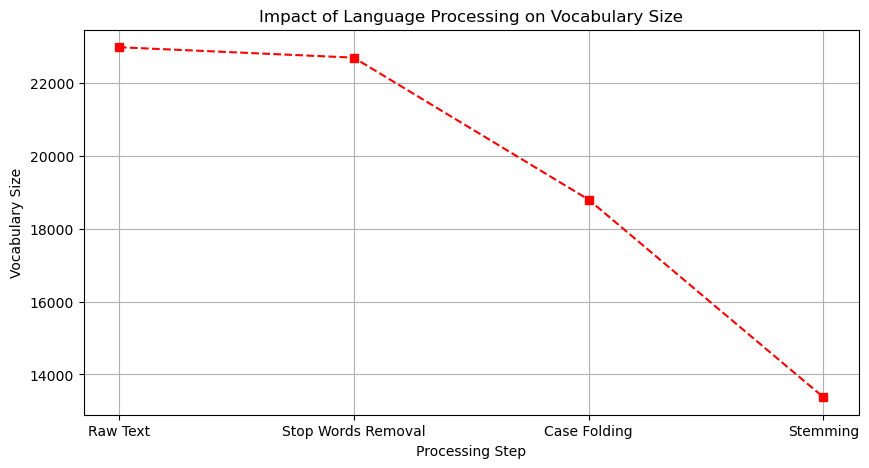

In [413]:
# נתונים
steps = ["Raw Text", "Stop Words Removal", "Case Folding", "Stemming"]
vocab_size = [22973, 22688, 18796, 13377]

# יצירת טבלה עם מספר המילים הייחודיות בכל שלב
df_unique_words = pd.DataFrame({"Stage": stages, "Unique Words": unique_words})
display(df_unique_words)

# יצירת גרף גודל אוצר המילים
plt.figure(figsize=(10, 5))
plt.plot(steps, vocab_size, marker='s', linestyle='--', color="red")
plt.xlabel("Processing Step")
plt.ylabel("Vocabulary Size")
plt.title("Impact of Language Processing on Vocabulary Size")
plt.grid(True)
plt.show()


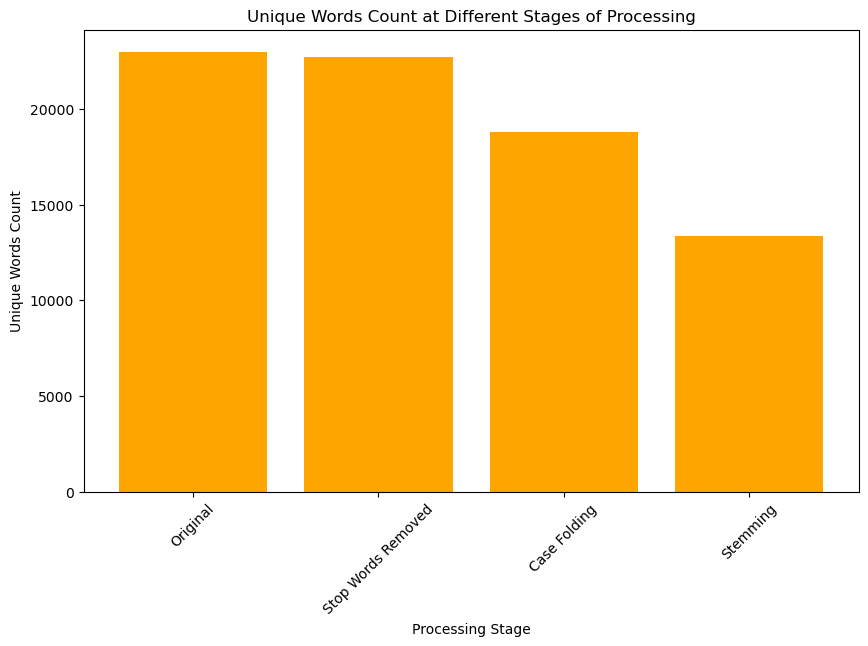

In [415]:
# יצירת גרף עמודות
plt.figure(figsize=(10, 6))
plt.bar(df_unique_words["Stage"], df_unique_words["Unique Words"], color='orange')
plt.xlabel("Processing Stage")
plt.ylabel("Unique Words Count")
plt.title("Unique Words Count at Different Stages of Processing")
plt.xticks(rotation=45)
plt.show()


,Original,Stop Words Removed,Case Folding,Stemming
Top 1,the,news,news,news
Top 2,of,user,user,user
Top 3,and,users,users,person
Top 4,to,recommendation,recommendation,recommend
Top 5,news,information,information,use
Top 6,in,personalization,personalization,model
Top 7,a,News,personalized,inform
Top 8,is,content,content,articl
Top 9,on,personalized,data,interest
Top 10,for,articles,media,system


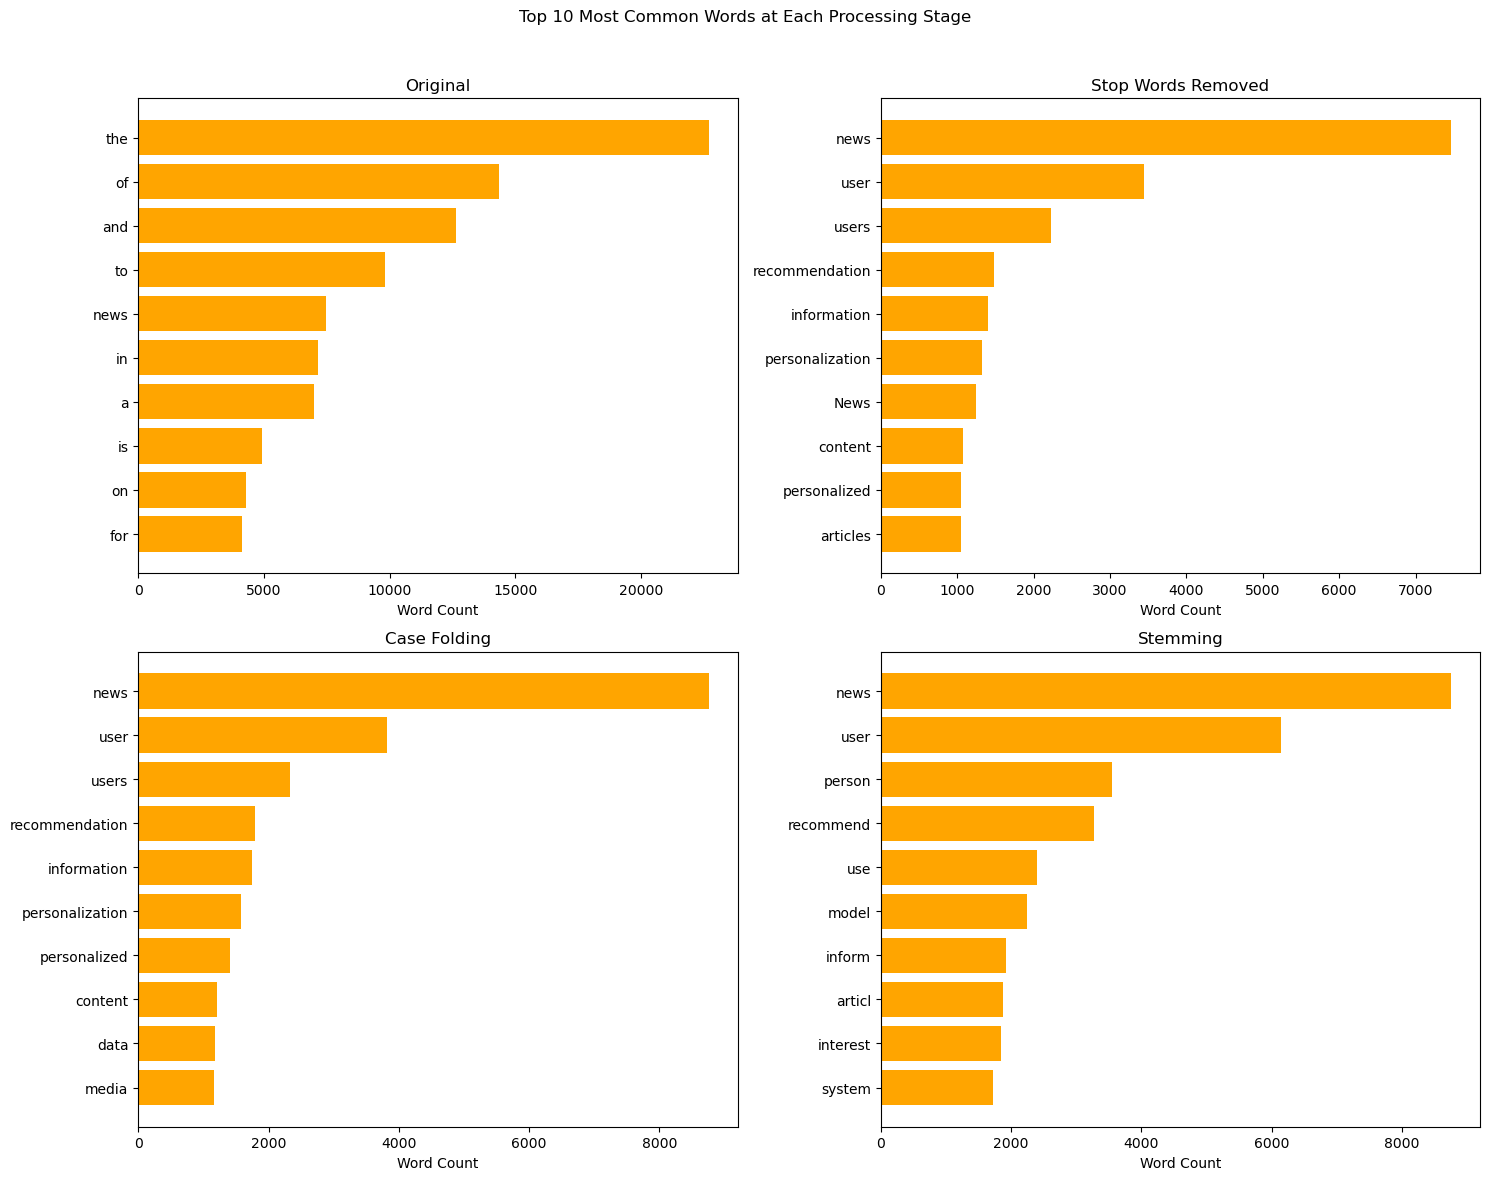

In [403]:
# יצירת DataFrame עבור המילים הנפוצות ביותר בכל שלב
common_words_data = {
    "Original": [('the', 22693), ('of', 14344), ('and', 12630), ('to', 9814), ('news', 7469), ('in', 7165), ('a', 6979), ('is', 4914), ('on', 4293), ('for', 4136)],
    "Stop Words Removed": [('news', 7469), ('user', 3440), ('users', 2228), ('recommendation', 1479), ('information', 1400), ('personalization', 1326), ('News', 1249), ('content', 1079), ('personalized', 1054), ('articles', 1052)],
    "Case Folding": [('news', 8761), ('user', 3814), ('users', 2332), ('recommendation', 1792), ('information', 1753), ('personalization', 1574), ('personalized', 1411), ('content', 1203), ('data', 1180), ('media', 1168)],
    "Stemming": [('news', 8761), ('user', 6146), ('person', 3543), ('recommend', 3271), ('use', 2404), ('model', 2241), ('inform', 1924), ('articl', 1884), ('interest', 1843), ('system', 1722)]
}

# המרת הנתונים לטבלה
common_words_df = pd.DataFrame({stage: [word[0] for word in words] for stage, words in common_words_data.items()})
common_words_df.index = [f"Top {i+1}" for i in range(10)]
display(common_words_df)  # הצגת טבלה אינטראקטיבית

# יצירת גרפים עבור המילים הנפוצות ביותר בכל שלב
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Top 10 Most Common Words at Each Processing Stage")

for ax, (stage, words) in zip(axes.flatten(), common_words_data.items()):
    words, counts = zip(*words)
    ax.barh(words[::-1], counts[::-1], color='orange')  # הופכים את הסדר כדי להציג נכון
    ax.set_title(stage)
    ax.set_xlabel("Word Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Text Classification

In [274]:
# הגדרת נתיבים לשתי התיקיות
directories = ["textTwitter", "text"]

# יצירת מילון לאחסון הקבצים והטקסט שלהם
documents = {}

# טעינת מסמכים מכל תיקייה
for folder_path in directories:
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith(".txt"):
            with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
                documents[filename] = file.read()

# יצירת DataFrame עם תוכן המסמכים
df_documents = pd.DataFrame(list(documents.items()), columns=["file name", "text"])

# ניקוי שמות הקבצים להסרת ".txt"
df_documents["file name"] = df_documents["file name"].str.replace(".txt", "", regex=False)

# הצגת מספר המסמכים שנטענו
print(f"נמצאו {len(df_documents)} מסמכים משתי התיקיות.")

# הצגת השורות הראשונות של הדאטה
from IPython.display import display
display(df_documents.head(100))


נמצאו 100 מסמכים משתי התיקיות.


,file name,text
0,1-s2.0-S187705092102411X-main,Available online at www.sciencedirect.com\nAva...
1,16_24,https://doi.org/10.20965/jdr.2021.p0024\nSonta...
2,18110-Article Text-21605-1-2-20210521,ProceedingsoftheFifteenthInternationalAAAIConf...
3,2002.10361v2,Multilingual Twitter Corpus and Baselines for ...
4,2003.12309v4,COVID-19 ON SOCIAL MEDIA: ANALYZING MISINFORMA...
...,...,...
95,User Interface Personalization in News Apps,﻿User Interface Personalization in News Apps \...
96,"User Modeling, Adaption, and Personalization",﻿Lecture Notes in Computer Science 6787 \nComm...
97,User Perspectives on the News Personalisation ...,﻿\nDigital Journalism \nISSN: (Print) (Online)...
98,User_attitudes_towards_news_content_pers,﻿ARTICLE IN PRESS \n\nInt. J. Human-Computer S...


In [434]:
# טוען את הקובץ csv
file_path = "filesRelevance.csv"
df_relevance = pd.read_csv(file_path)

print(f" מסמכים בקובץ CSV נמצאו {len(df_relevance)}.")
# מציג את השורות הראשונות של הקובץ
df_relevance.head()


 מסמכים בקובץ CSV נמצאו 100.


,file name,relevance
0,A Survey of Personalized News Recommendation,1
1,A Survey on Personalized News Recommendation T...,1
2,AContextual-BanditApproachto Personalized News...,1
3,Adaptive News Access,1
4,AI-News_Personalization_System_Combining_Compl...,1


In [430]:
# הגדרת נתיבי התיקיות
directories = ["text", "textTwitter"]

# מילון לאחסון המסמכים
documents = {}

# קריאת קובצי טקסט משתי התיקיות
for folder_path in directories:
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith(".txt"):
            with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
                documents[filename] = file.read()

# יצירת DataFrame עם הנתונים
df_documents = pd.DataFrame(list(documents.items()), columns=["file name", "text"])
df_documents["file name"] = df_documents["file name"].str.replace(".txt", "", regex=False)

# קריאת קובץ הרלוונטיות
csv_path = "filesRelevance.csv"
df_relevance = pd.read_csv(csv_path)
df_relevance["file name"] = df_relevance["file name"].str.strip()

# מיזוג הנתונים
df_merged = df_relevance.merge(df_documents, on="file name", how="inner")

# ניקוי טקסטים - הסרת פיסוק, אותיות קטנות, והסרת Stop Words
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    return " ".join(tokens)

df_merged["cleaned_text"] = df_merged["text"].apply(clean_text)

# הצגת מספר המסמכים שנטענו
print(f"נמצאו {len(df_merged)} מסמכים משתי התיקיות.")

# הצגת הטבלה לאחר עיבוד
from IPython.display import display
display(df_merged.head())


נמצאו 100 מסמכים משתי התיקיות.


,file name,relevance,text,cleaned_text
0,A Survey of Personalized News Recommendation,1,Data Science and Engineering (2023) 8:396416 \...,data science engineering 2023 8396416 httpsdoi...
1,A Survey on Personalized News Recommendation T...,1,"﻿Received August 25, 2019, accepted September ...",﻿received august 25 2019 accepted september 23...
2,AContextual-BanditApproachto Personalized News...,1,﻿A Contextual-Bandit Approach to \nPersonalize...,﻿a contextualbandit approach personalized news...
3,Adaptive News Access,1,﻿18 \nAdaptive News Access \nDaniel Billsus1...,﻿18 adaptive news access daniel billsus1 micha...
4,AI-News_Personalization_System_Combining_Compl...,1,"﻿Received 23 June 2023, accepted 6 August 2023...",﻿received 23 june 2023 accepted 6 august 2023 ...


In [436]:
# הגדרת התיקיות
directories = ["textTwitter", "text"]

# מילון לאחסון תוכן הקבצים
documents = {}

# טעינת מסמכים משתי התיקיות
for folder_path in directories:
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith(".txt"):
            with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
                documents[filename] = file.read()

# יצירת DataFrame עם הקבצים והטקסט שלהם
df_documents = pd.DataFrame(list(documents.items()), columns=["file name", "text"])

# ניקוי שמות הקבצים להסרת ".txt"
df_documents["file name"] = df_documents["file name"].str.replace(".txt", "", regex=False)

# קריאת קובץ ה-CSV עם תוויות הרלוונטיות
csv_path = "filesRelevance.csv"
df_relevance = pd.read_csv(csv_path)

# ניקוי שמות הקבצים בקובץ ה-CSV
df_relevance["file name"] = df_relevance["file name"].str.strip()

# מיזוג הנתונים לפי "file name"
df_merged = df_relevance.merge(df_documents, on="file name", how="inner")

#  הצגת מספר המסמכים אחרי המיזוג
print(f"נמצאו {len(df_merged)}  מסמכים עם תוויות של רלוונטיות או אי רלוונטיות.")

# ניקוי הטקסטים (המרה לאותיות קטנות, הסרת פיסוק, והסרת Stop Words)
def clean_text(text):
    text = text.lower()  # המרה לאותיות קטנות
    text = text.translate(str.maketrans("", "", string.punctuation))  # הסרת סימני פיסוק
    tokens = text.split()  # פיצול לפי רווחים
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]  # הסרת מילות עצירה
    return " ".join(tokens)

# החלת הניקוי על כל המסמכים
df_merged["cleaned_text"] = df_merged["text"].apply(clean_text)

from IPython.display import display
display(df_merged.head(10))


נמצאו 100  מסמכים עם תוויות של רלוונטיות או אי רלוונטיות.


,file name,relevance,text,cleaned_text
0,A Survey of Personalized News Recommendation,1,Data Science and Engineering (2023) 8:396416 \...,data science engineering 2023 8396416 httpsdoi...
1,A Survey on Personalized News Recommendation T...,1,"﻿Received August 25, 2019, accepted September ...",﻿received august 25 2019 accepted september 23...
2,AContextual-BanditApproachto Personalized News...,1,﻿A Contextual-Bandit Approach to \nPersonalize...,﻿a contextualbandit approach personalized news...
3,Adaptive News Access,1,﻿18 \nAdaptive News Access \nDaniel Billsus1...,﻿18 adaptive news access daniel billsus1 micha...
4,AI-News_Personalization_System_Combining_Compl...,1,"﻿Received 23 June 2023, accepted 6 August 2023...",﻿received 23 june 2023 accepted 6 august 2023 ...
5,Algorithms and System Architecture for Immedia...,1,﻿Algorithms and System Architecture for Immedi...,﻿algorithms architecture immediate personalize...
6,An_adaptive_personalized_news_disseminat,1,﻿J Intell Inf Syst (2009) 32:191–212 \nDOI 10....,﻿j intell inf syst 2009 32191–212 doi 101007s1...
7,Anadaptive system for the personalized access ...,1,﻿1 \nAn adaptive system for the personalized a...,﻿1 adaptive personalized access news liliana a...
8,Analyzing the News Coverage of Personalized Ne...,1,﻿2018 IEEE/ACM International Conference on Adv...,﻿2018 ieeeacm international conference advance...
9,DoNotReadtheSameNews!,1,﻿Do Not Read the Same News! \nEnhancing Divers...,﻿do read news enhancing diversity personalizat...


In [453]:
# יצירת ייצוג TF-IDF לטקסטים הנקיים
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_merged["cleaned_text"])
y = df_merged["relevance"]

# חלוקת הנתונים לאימון ובדיקה (90% אימון, 10% בדיקה)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# הגדרת המסווגים
models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}

# אחסון תוצאות ה-F1 ממוצע (Cross Validation)
cv_results = {}

# אחסון Precision, Recall, ו-F1 לכל קטגוריה
detailed_results = {}

for name, model in models.items():
    # חישוב Cross Validation עם 10 חלקים
    f1_scores = cross_val_score(model, X_train, y_train, cv=10, scoring="f1")
    cv_results[name] = f1_scores.mean()
    
    # אימון המודל על כל סט האימון
    model.fit(X_train, y_train)
    
    # חיזוי על סט הבדיקה
    y_pred = model.predict(X_test)
    
    # חישוב Precision, Recall, ו-F1
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
    
    detailed_results[name] = {
        "Precision (Class 0)": precision[0],
        "Recall (Class 0)": recall[0],
        "F1 Score (Class 0)": f1[0],
        "Precision (Class 1)": precision[1],
        "Recall (Class 1)": recall[1],
        "F1 Score (Class 1)": f1[1]
    }

# המרת תוצאות Cross Validation לטבלה
df_cv_results = pd.DataFrame.from_dict(cv_results, orient="index", columns=["F1 Score (CV)"])

# המרת תוצאות Precision, Recall ו-F1 לטבלה
df_detailed_results = pd.DataFrame.from_dict(detailed_results, orient="index")

תוצאות ממוצעות של 10-Fold Cross Validation באמצעות F1:

In [440]:
#  הצגת טבלת Cross Validation
display(df_cv_results)

 תוצאות ממוצעות של F1 באמצעות 10-Fold Cross Validation:


,F1 Score (CV)
Naïve Bayes,0.910303
Logistic Regression,0.963492
SVM,0.963492
Random Forest,0.955556


:לכל קטגוריה Precision, Recall, F1  
Class 0 - Not Relevant  
Class 1 - Relevant

In [451]:
#  הצגת Precision, Recall ו-F1 בטבלה מפורטת
display(df_detailed_results)

,Precision (Class 0),Recall (Class 0),F1 Score (Class 0),Precision (Class 1),Recall (Class 1),F1 Score (Class 1)
Naïve Bayes,1.0,1.00,1.000000,1.000000,1.0,1.000000
Logistic Regression,1.0,1.00,1.000000,1.000000,1.0,1.000000
SVM,1.0,1.00,1.000000,1.000000,1.0,1.000000
Random Forest,1.0,0.75,0.857143,0.857143,1.0,0.923077


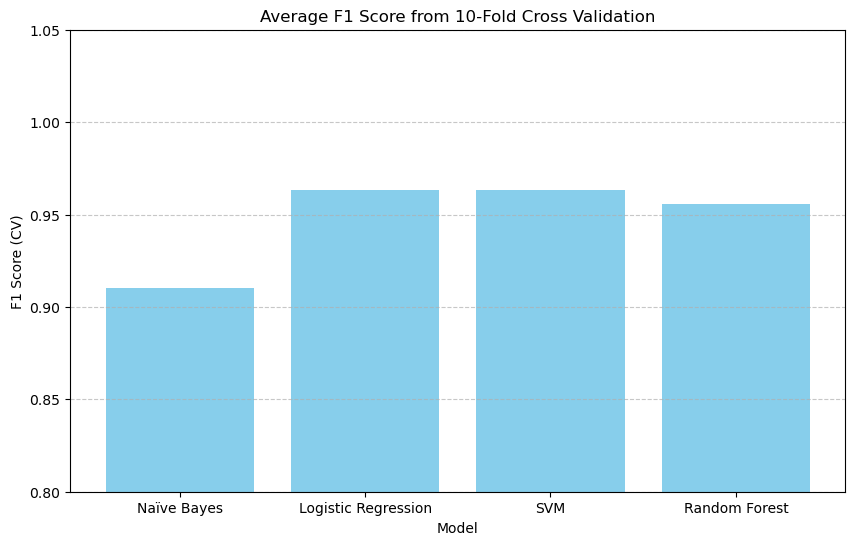

In [470]:
# תוצאות Cross Validation
cv_results = {
    "Naïve Bayes": 0.910303,
    "Logistic Regression": 0.963492,
    "SVM": 0.963492,
    "Random Forest": 0.955556
}

# יצירת גרף F1 Score ממוצע עבור Cross Validation
plt.figure(figsize=(10, 6))
plt.bar(cv_results.keys(), cv_results.values(), color="skyblue")
plt.xlabel("Model")
plt.ylabel("F1 Score (CV)")
plt.title("Average F1 Score from 10-Fold Cross Validation")
plt.ylim(0.8, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

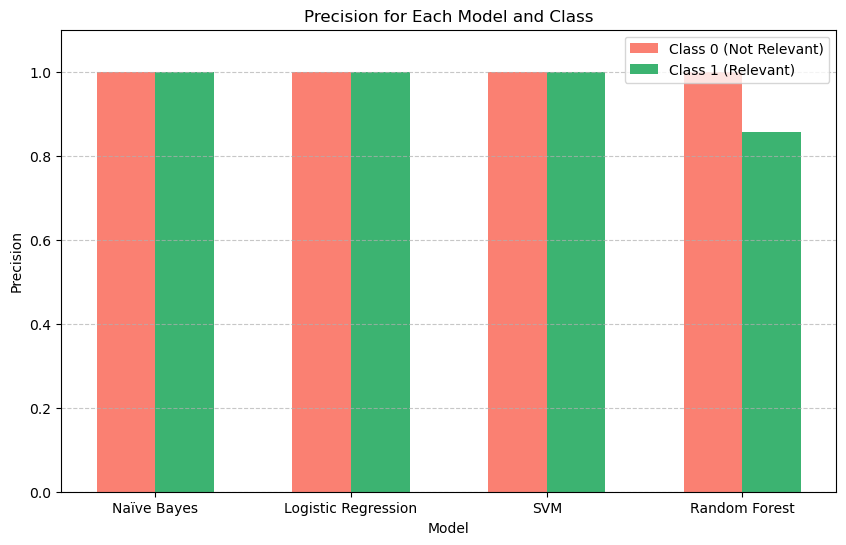

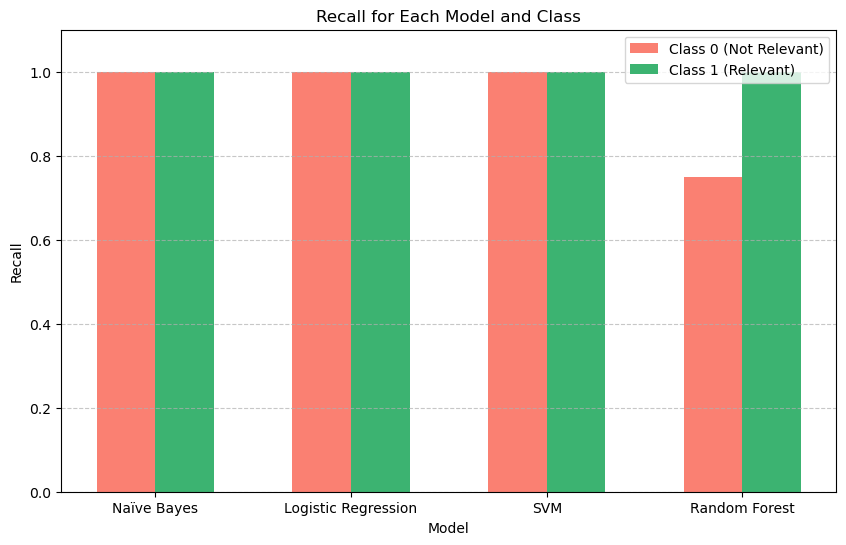

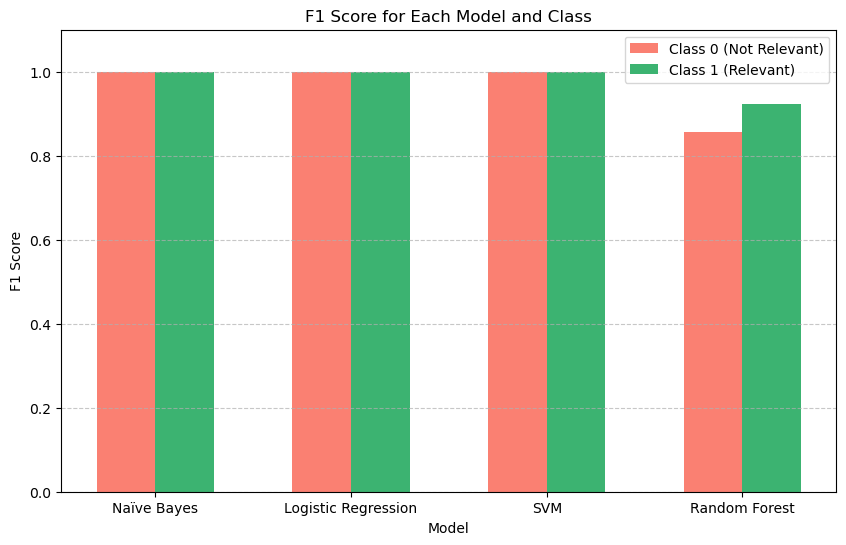

In [468]:

# תוצאות Precision, Recall ו-F1 לכל קטגוריה
detailed_results = {
    "Naïve Bayes": {
        "Precision (Class 0)": 1.0,
        "Recall (Class 0)": 1.00,
        "F1 Score (Class 0)": 1.000000,
        "Precision (Class 1)": 1.000000,
        "Recall (Class 1)": 1.0,
        "F1 Score (Class 1)": 1.000000
    },
    "Logistic Regression": {
        "Precision (Class 0)": 1.0,
        "Recall (Class 0)": 1.00,
        "F1 Score (Class 0)": 1.000000,
        "Precision (Class 1)": 1.000000,
        "Recall (Class 1)": 1.0,
        "F1 Score (Class 1)": 1.000000
    },
    "SVM": {
        "Precision (Class 0)": 1.0,
        "Recall (Class 0)": 1.00,
        "F1 Score (Class 0)": 1.000000,
        "Precision (Class 1)": 1.000000,
        "Recall (Class 1)": 1.0,
        "F1 Score (Class 1)": 1.000000
    },
    "Random Forest": {
        "Precision (Class 0)": 1.0,
        "Recall (Class 0)": 0.75,
        "F1 Score (Class 0)": 0.857143,
        "Precision (Class 1)": 0.857143,
        "Recall (Class 1)": 1.0,
        "F1 Score (Class 1)": 0.923077
    }
}

# יצירת גרף Precision, Recall ו-F1 עבור כל קטגוריה ומודל
metrics = ["Precision", "Recall", "F1 Score"]
classes = ["Class 0 (Not Relevant)", "Class 1 (Relevant)"]
models = list(detailed_results.keys())

# ציור הגרפים לכל מדד
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.3
    x = np.arange(len(models))

    # גרפים לכל קטגוריה
    values_class_0 = [detailed_results[model][f"{metric} (Class 0)"] for model in models]
    values_class_1 = [detailed_results[model][f"{metric} (Class 1)"] for model in models]

    ax.bar(x - width / 2, values_class_0, width, label=classes[0], color="salmon")
    ax.bar(x + width / 2, values_class_1, width, label=classes[1], color="mediumseagreen")

    ax.set_xlabel("Model")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} for Each Model and Class")
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.set_ylim(0, 1.1)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Text Clustering

In [769]:
# הגדרת התיקיות המכילות את המסמכים
folders = ["text", "textTwitter", "indoorPositionInCultureHeritage", "imageBasedPosition"]

#  קריאת קובץ ה-CSV שמכיל שמות מסמכים, תיקיות ו-True Labels
csv_path = "filesClusters.csv"  # עדכני לנתיב של ה-CSV
df = pd.read_csv(csv_path)
df['file name'] = df['file name'].str.strip().str.lower()  # ניקוי שמות הקבצים

In [771]:
# קריאת המסמכים מכל תיקייה בנפרד
documents = {}
for folder in folders:
    folder_path = os.path.abspath(folder)  # יצירת נתיב מוחלט
    if os.path.exists(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                try:
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                        documents[file_name.lower().strip()] = file.read()
                except Exception as e:
                    print(f"Error reading {file_name}: {e}")
    else:
        print(f"Folder not found: {folder_path}")

In [773]:
# ניקוי כל המסמכים
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    stop_words = set(["the", "and", "to", "of", "a", "in", "is", "for", "on", "that", "by", "this", "with", "i", "you", "it", "not", "or", "be", "are", "from", "at", "as", "your", "have", "more", "an", "was", "we", "will", "if", "can", "all", "our", "has", "so", "but", "there", "their", "what", "about", "which", "when", "one", "were", "also", "they", "how", "some", "just", "into", "only", "being", "than", "such", "many", "any", "those", "my", "these", "would", "me", "like", "other", "them", "its", "do", "out", "should", "up", "he", "she", "him", "her"])
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

cleaned_documents = {file: clean_text(content) for file, content in documents.items()}

In [775]:
# 6. המרת טקסטים ל-TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(cleaned_documents.values())

In [777]:
# יצירת אשכולות K-means
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X)


KMeans(n_clusters=4, n_init=10, random_state=42)

In [779]:
# שיוך מסמכים לאשכולות
cluster_results = pd.DataFrame({
    'File': list(cleaned_documents.keys()),
    'Cluster': kmeans.labels_
})

In [781]:
# הוספת תוויות אמת (True Labels)
df['file name'] = df['file name'].str.strip().str.lower()
df['file name'] = df['file name'].str.strip().str.lower().str.replace('.txt$', '', regex=True)
cluster_results['File'] = cluster_results['File'].str.replace('.txt$', '', regex=True)
cluster_results['File'] = cluster_results['File'].str.strip().str.lower()
cluster_results = cluster_results.merge(df[['file name', 'true label']], left_on='File', right_on='file name', how='left')
true_labels = cluster_results['true label'].fillna(-1).astype(int).values

In [783]:
#  חישוב מדדים להערכת K-means
silhouette_avg = silhouette_score(X, kmeans.labels_)
davies_bouldin = davies_bouldin_score(X.toarray(), kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(X.toarray(), kmeans.labels_)
adjusted_rand = adjusted_rand_score(true_labels, kmeans.labels_)
nmi = normalized_mutual_info_score(true_labels, kmeans.labels_)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")
print(f"Adjusted Rand Index: {adjusted_rand}")
print(f"Normalized Mutual Information Score: {nmi}")

Silhouette Score: 0.1286824078051034
Davies-Bouldin Index: 2.614449410122627
Calinski-Harabasz Index: 18.744875348382763
Adjusted Rand Index: 0.9213698154871777
Normalized Mutual Information Score: 0.8996458431521895


In [785]:
# הצגת טבלה נפרדת לכל אשכול
for cluster_num in range(num_clusters):
    cluster_subset = cluster_results[cluster_results['Cluster'] == cluster_num]
    num_rows = len(cluster_subset)
    print(f"Cluster {cluster_num} - {num_rows} Documents:")
    display(cluster_subset)
    print("\n")

Cluster 0 - 49 Documents:


,File,Cluster,file name,true label
46,"user modeling, adaption, and personalization",0,"user modeling, adaption, and personalization",1
50,1-s2.0-s187705092102411x-main,0,1-s2.0-s187705092102411x-main,0
51,16_24,0,16_24,0
52,18110-article text-21605-1-2-20210521,0,18110-article text-21605-1-2-20210521,0
53,2002.10361v2,0,2002.10361v2,0
54,2003.12309v4,0,2003.12309v4,0
55,2004.02192v3,0,2004.02192v3,0
56,2020.acl-main.50,0,2020.acl-main.50,0
57,2023-42409,0,2023-42409,0
58,2104.06182v1,0,2104.06182v1,0




Cluster 1 - 50 Documents:


,File,Cluster,file name,true label
0,a survey of personalized news recommendation,1,a survey of personalized news recommendation,1
1,a survey on personalized news recommendation t...,1,a survey on personalized news recommendation t...,1
2,acontextual-banditapproachto personalized news...,1,acontextual-banditapproachto personalized news...,1
3,adaptive news access,1,adaptive news access,1
4,ai-news_personalization_system_combining_compl...,1,ai-news_personalization_system_combining_compl...,1
5,algorithms and system architecture for immedia...,1,algorithms and system architecture for immedia...,1
6,anadaptive system for the personalized access ...,1,anadaptive system for the personalized access ...,1
7,analyzing the news coverage of personalized ne...,1,analyzing the news coverage of personalized ne...,1
8,an_adaptive_personalized_news_disseminat,1,an_adaptive_personalized_news_disseminat,1
9,donotreadthesamenews!,1,donotreadthesamenews!,1




Cluster 2 - 54 Documents:


,File,Cluster,file name,true label
76,3479594,2,3479594,0
101,3d reconstruction of spherical images a review...,2,3d reconstruction of spherical images a review...,3
135,mobile phone indoor scene features recognition...,2,mobile phone indoor scene features recognition...,3
150,1-s2.0-0042698995001301-main_00001,2,1-s2.0-0042698995001301-main_00001,2
151,1-s2.0-026151779190045u-main_00001,2,1-s2.0-026151779190045u-main_00001,2
152,1-s2.0-s0030402604702442-main_00001,2,1-s2.0-s0030402604702442-main_00001,2
153,1-s2.0-s0888327016300127-main_00001,2,1-s2.0-s0888327016300127-main_00001,2
154,1-s2.0-s2405631622000884-main_00001,2,1-s2.0-s2405631622000884-main_00001,2
155,1998_lncis_chaumette_00001,2,1998_lncis_chaumette_00001,2
156,2006_itro_pages_00001,2,2006_itro_pages_00001,2




Cluster 3 - 49 Documents:


,File,Cluster,file name,true label
100,3d lidar and multi-technology collaboration fo...,3,3d lidar and multi-technology collaboration fo...,3
102,3d surveying of underground built heritage opp...,3,3d surveying of underground built heritage opp...,3
103,a framework study on the use of immersive xr t...,3,a framework study on the use of immersive xr t...,3
104,a review of recent research in indoor modellin...,3,a review of recent research in indoor modellin...,3
105,a scoping review on the use processing and fus...,3,a scoping review on the use processing and fus...,3
106,a state-of-the-art review on the integration o...,3,a state-of-the-art review on the integration o...,3
107,a survey of museum applied research based on m...,3,a survey of museum applied research based on m...,3
108,a survey on developing personalized content se...,3,a survey on developing personalized content se...,3
109,a systematic review of digital transformation ...,3,a systematic review of digital transformation ...,3
110,accessible wayfnding and navigation a systemat...,3,accessible wayfnding and navigation a systemat...,3


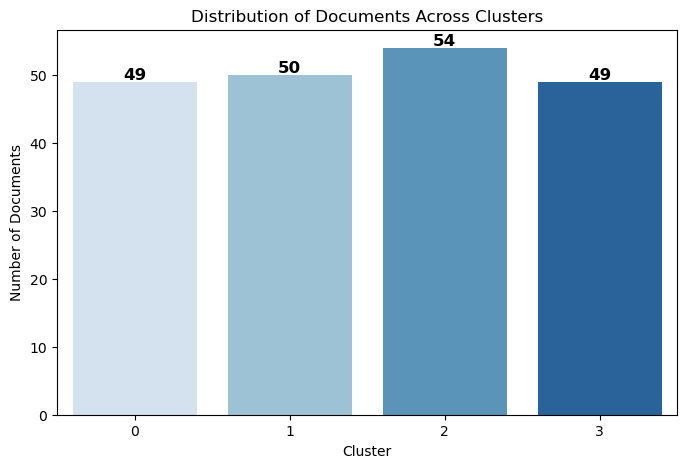

In [811]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x=kmeans.labels_, palette="Blues")  # יצירת גרף עמודות

# הוספת מספרים מעל כל עמודה
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # המספר של המסמכים באשכול
                (p.get_x() + p.get_width() / 2., p.get_height()),  # מיקום
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.xlabel("Cluster")
plt.ylabel("Number of Documents")
plt.title("Distribution of Documents Across Clusters")
plt.show()

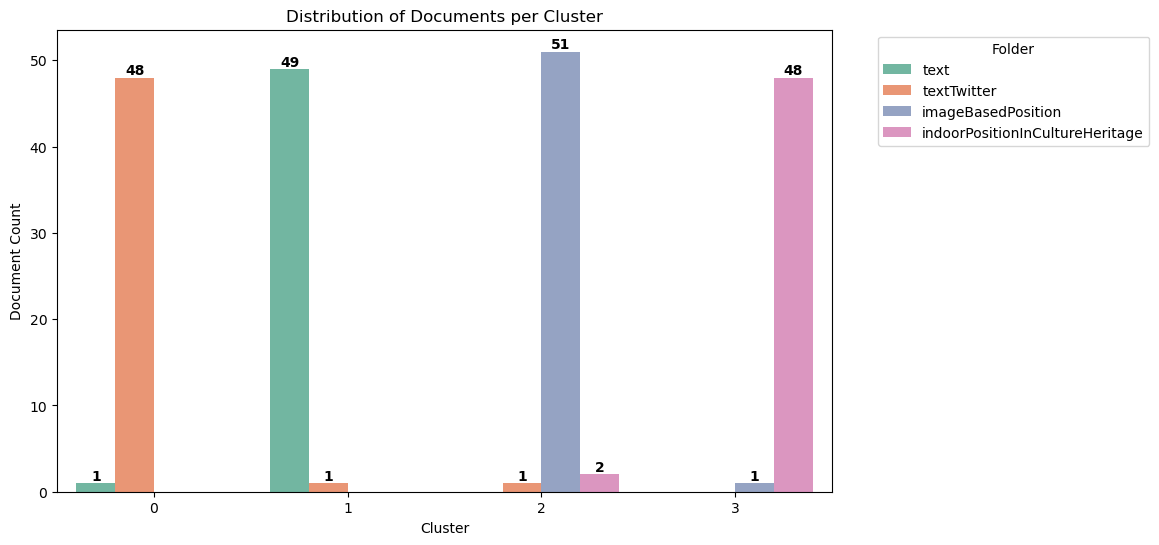

In [831]:
# יצירת גרף עמודות עם מספר המסמכים מעל כל עמודה
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Cluster", y="Document Count", hue="folder", data=cluster_counts, palette="Set2")

# הוספת מספרים מעל כל עמודה עם טיפול בערכים חסרים
for p in ax.patches:
    value = p.get_height()
    if not np.isnan(value):  # בדיקה אם הערך הוא מספר תקין
        ax.annotate(f'{int(value)}',  
                    (p.get_x() + p.get_width() / 2., value),  
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# הזזת המקרא מחוץ לגרף (לצד ימין)
plt.legend(title="Folder", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Cluster")
plt.ylabel("Document Count")
plt.title("Distribution of Documents per Cluster")
plt.show()

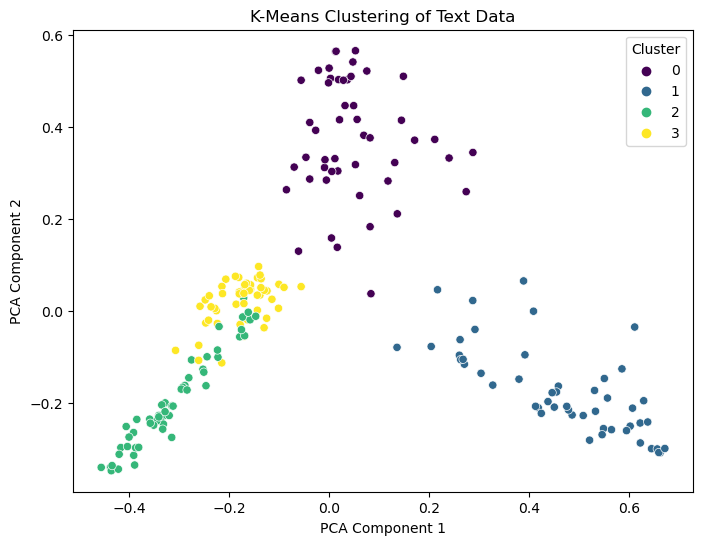

In [791]:
# 12. PCA להמחשת האשכולות
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
plt.figure(figsize=(8,6))
scatter = sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans.labels_, palette='viridis')
plt.title("K-Means Clustering of Text Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

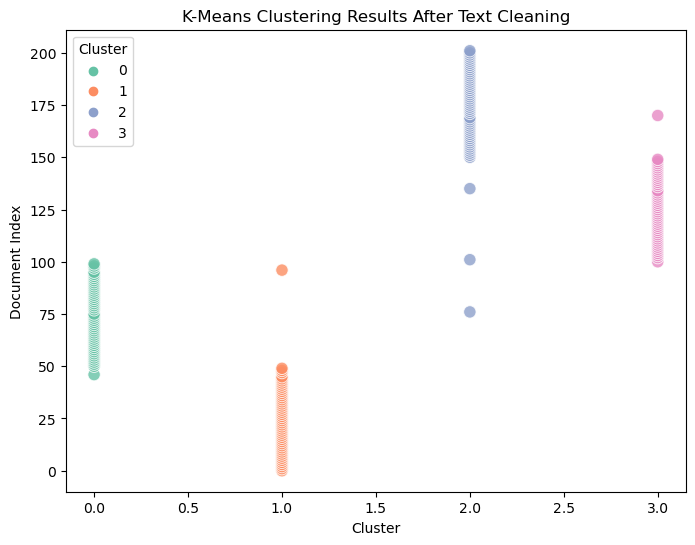

In [833]:
# יצירת DataFrame עם התוצאות
df_clusters = cluster_results.copy()
df_clusters['Document Index'] = df_clusters.index  # יצירת אינדקס דוקומנטים

# יצירת גרף פיזור להצגת אשכולות
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_clusters['Cluster'], y=df_clusters['Document Index'], hue=df_clusters['Cluster'], palette="Set2", s=80, alpha=0.8)

# הוספת כותרות
plt.xlabel("Cluster")
plt.ylabel("Document Index")
plt.title("K-Means Clustering Results After Text Cleaning")
plt.legend(title="Cluster")
plt.show()

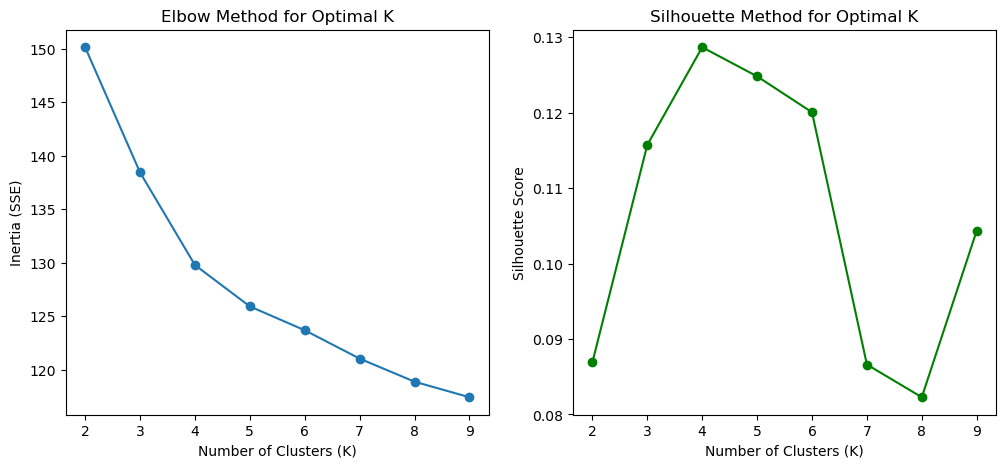

In [793]:
# שיטת המרפק למציאת K אופטימלי
inertia = []
silhouette_scores = []
k_range = range(2,10)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X, km.labels_))

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(k_range, inertia, marker='o')
ax[0].set_xlabel("Number of Clusters (K)")
ax[0].set_ylabel("Inertia (SSE)")
ax[0].set_title("Elbow Method for Optimal K")
ax[1].plot(k_range, silhouette_scores, marker='o', color='green')
ax[1].set_xlabel("Number of Clusters (K)")
ax[1].set_ylabel("Silhouette Score")
ax[1].set_title("Silhouette Method for Optimal K")
plt.show()

In [801]:
# חישוב Precision, Recall, F1-Score, ו- Accuracy
precision = precision_score(true_labels, kmeans.labels_, average='macro')
recall = recall_score(true_labels, kmeans.labels_, average='macro')
f1 = f1_score(true_labels, kmeans.labels_, average='macro')
accuracy = accuracy_score(true_labels, kmeans.labels_)


print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" Accuracy: {accuracy:.4f}")

 Precision: 0.9709
 Recall: 0.9702
 F1 Score: 0.9704
 Accuracy: 0.9703


In [805]:
def purity_score(y_true, y_pred):
    # יצירת טבלת צירופים של true labels ו-predicted clusters
    contingency_matrix = np.zeros((len(set(y_pred)), len(set(y_true))))

    for i, label in enumerate(set(y_pred)):
        cluster_indices = np.where(y_pred == label)[0]  # דוגמאות השייכות לאשכול זה
        true_labels_in_cluster = y_true[cluster_indices]  # תוויות אמת באשכול זה
        label_counts = Counter(true_labels_in_cluster)  # ספירת שכיחויות התוויות
        most_common_label_count = max(label_counts.values())  # מספר הדוגמאות מהתווית הדומיננטית
        contingency_matrix[i, list(set(y_true)).index(max(label_counts, key=label_counts.get))] = most_common_label_count

    # חישוב Purity
    total_correct = np.sum(np.max(contingency_matrix, axis=1))
    purity = total_correct / len(y_true)
    
    return purity

# חישוב Purity עבור K-Means
purity = purity_score(true_labels, kmeans.labels_)
print(f" Purity Score: {purity:.4f}")

 Purity Score: 0.9703
